# Local Learning on CIFAR10

In [173]:
# define colorscheme

colorwheel = ['#762a83','#af8dc3','#e7d4e8','#d9f0d3','#7fbf7b','#1b7837']

In [1]:
import torch
from torchvision.transforms import ToTensor
from pathlib import Path
from context import LocalLearning
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
trained_weights_path = Path("../data/models/L3UnitCIFAR10_LL/cifar_1000.pth")
#trained_weights_path = Path("../data/models/MikkelNormalizedCIFAR10_LL/cifar_1000.pth")


with torch.no_grad():
    trained_state = torch.load(trained_weights_path)
    model_ps = trained_state["model_parameters"]
    model = LocalLearning.FKHL3(model_ps)
    model.eval()
    model.load_state_dict(trained_state["model_state_dict"])
    #model.to(device)
    #l_n_trained = LocalLearning.cov_spectrum(test_dataloader, model, device)
    #l_n_trained = l_n_trained.to(cpu).numpy()

In [4]:
BATCH_SIZE = 1000

cifar10Test = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=model.pSet["p"],
)

TestLoader = LocalLearning.DeviceDataLoader(
    cifar10Test,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

Files already downloaded and verified


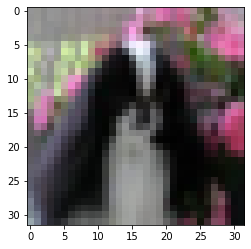

In [5]:
features, labels = next(iter(TestLoader))

def MinMaxNorm(x: np.array) -> np.array:
    mi = np.amin(x)
    ma = np.amax(x)
    return (x - mi) / (ma - mi)
    
f_np = features.detach().cpu().numpy()
HM = np.zeros((32, 32, 3))
HM = np.transpose(f_np[42], (0, 1, 2))
HM = MinMaxNorm(HM)
nc = np.max(np.absolute(HM))
fig, ax = plt.subplots()
ax.imshow(HM, vmin=-nc, vmax=+nc)

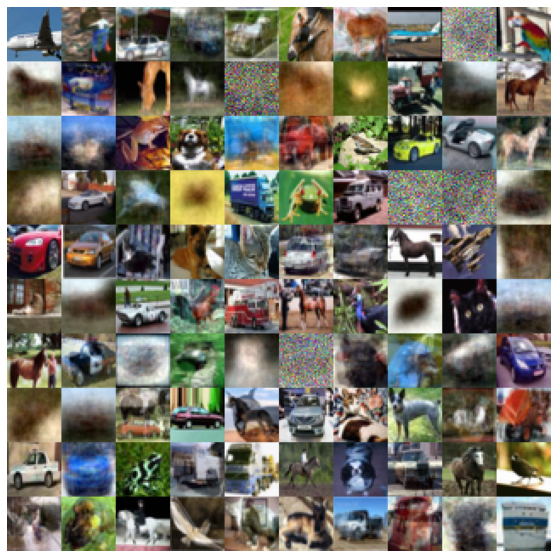

In [6]:
def minmaxnorm(a):
    a_ = a - a.min()
    return a_ / a_.max()

def draw_weights(synapses, n_hiddenx, n_hiddeny, n_pixelx=32, n_pixely=32, n_chan=3):
    cnt = 0
    synapses = synapses[np.random.choice(synapses.shape[0], n_hiddenx*n_hiddeny, replace=False)]
    HM = np.zeros((n_pixely*n_hiddeny, n_pixelx*n_hiddenx, n_chan))
    for y in range(n_hiddeny):
        for x in range(n_hiddenx):
            HM[y*n_pixely:(y+1)*n_pixely, x*n_pixelx:(x+1)*n_pixelx, :] = minmaxnorm(synapses[cnt].reshape(n_pixely, n_pixelx, n_chan))
            cnt += 1

    nc = np.max(np.absolute(HM))
    im = plt.imshow(HM, vmin=-nc, vmax=nc)
    plt.axis('off')
    
fig = plt.figure(figsize = (12.9, 10))
draw_weights(model.W.T.detach().cpu().numpy(), 10, 10)

In [7]:
def MinMaxNorm(x: np.array) -> np.array:
    mi = np.amin(x)
    ma = np.amax(x)
    return (x - mi) / (ma - mi)

(-0.5, 319.5, 319.5, -0.5)

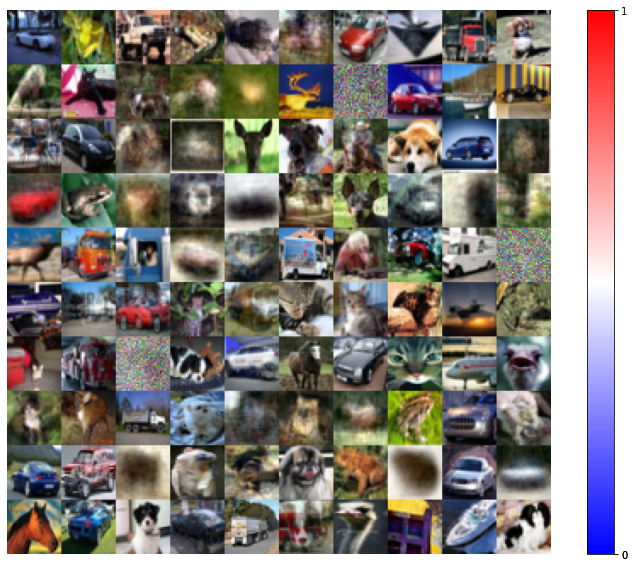

In [8]:
Kx = 10
Ky = 10

W = model.W.detach().cpu().clone().numpy()
W = W.T
W = W[np.random.choice(W.shape[0], Kx*Ky, replace=False)]

fig, ax = plt.subplots(figsize=(12.9, 10))
yy=0
HM=np.zeros((32*Ky, 32*Kx, 3))
for y in range(Ky):
    for x in range(Kx):
        HM[y*32:(y+1)*32,x*32:(x+1)*32, :]=MinMaxNorm(W[yy].reshape(32, 32, 3))
        yy += 1
#plt.clf()
nc=np.amax(np.absolute(HM))
im=ax.imshow(HM,cmap='bwr')#,vmin=-nc,vmax=nc)
fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
ax.axis('off')
#fig.show()

## Introduce Gaussian Noise as a Signal

In [10]:
gauss_p = torch.rand(len(TestLoader)*BATCH_SIZE, model.pSet["in_size"])
gauss_p = gauss_p.normal_(mean=0.0, std=1.0)

In [11]:
def sig_spectrum(signal: torch.Tensor, batch_size=1000) -> torch.Tensor:
    # calculates the ordered power spectrum of a signal
    # Args:
    #    signal (torch.Tensor):    shape = (ensemble_size, signal_dim, )
    #    batch_size (int):         size of the batches to create for processing
    # Vals:
    #     lambda_n (torch.Tensor):    size = (signal_dim, )
    
    with torch.no_grad():
        # draw parameters from input
        no_comp = signal.size(dim=-1) # number of components
        device = signal.device
        dtype = signal.dtype
        
        auto_corr = torch.zeros((no_comp, no_comp), device=device, dtype=dtype)
        mean = torch.zeros((no_comp, ), device=device, dtype=dtype)
        pop_size = 0
        
        # shift = estimate of the mean
        K = signal[0].mean()
        
        no_batches = int(len(signal) // batch_size)
        with tqdm(range(no_batches), unit="batch") as t_batch_idx:
            t_batch_idx.set_description(f"Calculating spectral components")
            for s_idx in t_batch_idx:
                batch = signal[s_idx*batch_size:(s_idx+1)*batch_size]
                data = batch - K
                auto_corr += data.T @ data
                mean += data.sum(axis=0)
                
        cov = auto_corr - mean[None].T @ mean[None] / no_batches
        cov /= no_batches - 1
        
        # cov matrix is real valued
        # -> [cov, cov.adjoint] = 0
        # -> eigenvalues are real
        l_real = torch.linalg.eigvals(cov).real
        lambda_n, _ = torch.sort(l_real, descending=True)
            
    return lambda_n

In [12]:
l_n_gauss_p = sig_spectrum(gauss_p)
l_n_gauss_p_np = l_n_gauss_p.detach().cpu().numpy()

  0%|          | 0/10 [00:00<?, ?batch/s]

## CIFAR10 Testset Spectrum

In [27]:
cifar10_test_tensor = TestLoader.dataset.data.reshape((10000, 32*32*3)).clone()
cifar10_spectrum = sig_spectrum(cifar10_test_tensor)
cifar10_spectrum_np = cifar10_spectrum.detach().cpu().numpy()

  0%|          | 0/10 [00:00<?, ?batch/s]

## Compare the model's spectrum to the dataset's and white noise's

In [9]:
# Calculate CIFAR10 Test Spectrum

with torch.no_grad():
    model.to(device)
    l_n_trained = LocalLearning.cov_spectrum(TestLoader, model, device)
    l_n_trained = l_n_trained.to(torch.device('cpu')).numpy()

Calculating covariance spectrum: 100%|███████████████| 10/10 [00:00<00:00, 17.83batch/s]


In [13]:
# model prediction from white noise
gauss_pred = model(gauss_p.to(device))
# calculate encoding spectrum for white noise encodings
l_n_gauss_pred = sig_spectrum(gauss_pred)
l_n_gauss_pred_np = l_n_gauss_pred.detach().cpu().numpy()

  0%|          | 0/10 [00:00<?, ?batch/s]

In [39]:
# untrained model
# retrieve the same parameter set as for the trained model
virgin_model_ps = trained_state["model_parameters"]
virgin_model = LocalLearning.FKHL3(virgin_model_ps)
virgin_model.to(device)
virgin_model.eval()

In [43]:
# calculate virgin model's spectra
# Gaussian Noise
virgin_gauss_pred = virgin_model(gauss_p.to(device))
l_n_vgauss_pred = sig_spectrum(virgin_gauss_pred)
l_n_vgauss_pred_np = l_n_vgauss_pred.detach().cpu().numpy()

l_n_virgin = LocalLearning.cov_spectrum(TestLoader, virgin_model, device)
l_n_virgin_np = l_n_virgin.detach().cpu().numpy()

  0%|          | 0/10 [00:00<?, ?batch/s]

Calculating covariance spectrum: 100%|██████████████| 10/10 [00:00<00:00, 473.67batch/s]


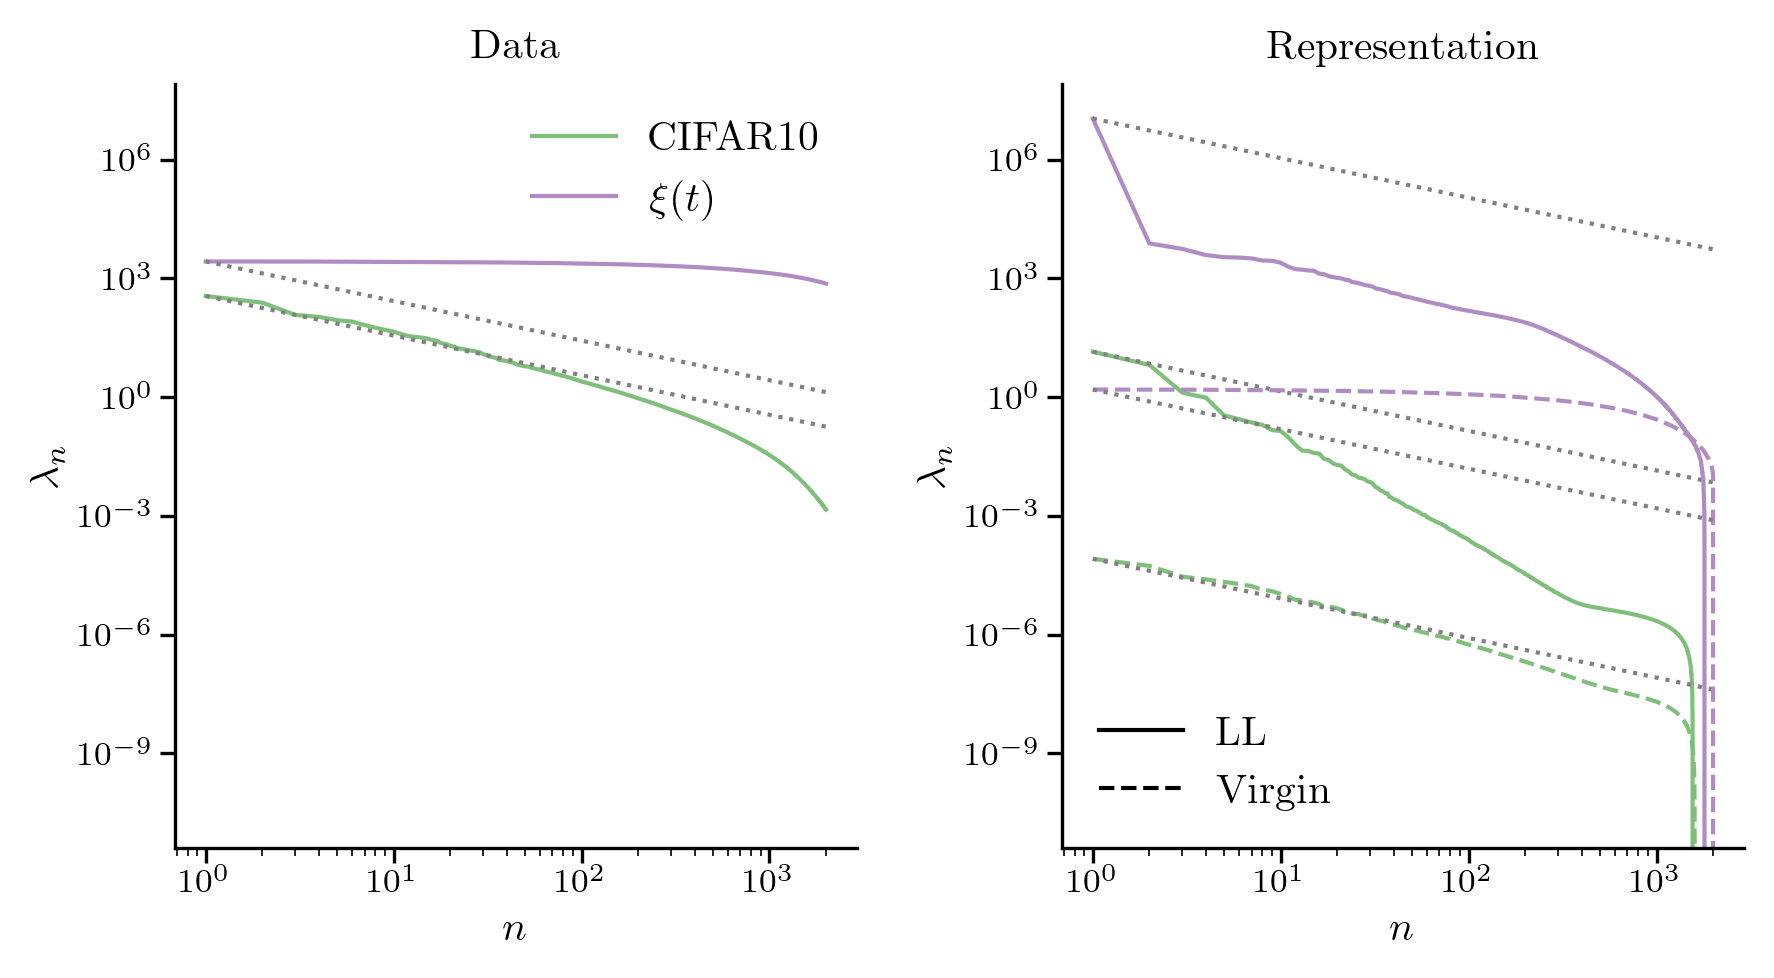

In [189]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

fig, axs = plt.subplots(1, 2)

c = colorwheel

# title
axs[0].set_title(r"Data")
# plots
axs[0].loglog(np.arange(1, len(l_n_trained)+1), cifar10_spectrum_np[:len(l_n_trained)], label=r"CIFAR10",\
              color=c[-2])
axs[0].loglog(np.arange(1, len(l_n_trained)+1), cifar10_spectrum_np[0] / np.arange(1, len(l_n_trained)+1),\
              color="grey", linestyle="dotted")
axs[0].loglog(np.arange(1, len(l_n_trained)+1), l_n_gauss_p_np[:len(l_n_trained)], label=r"$\xi(t)$",\
              color=c[1])
axs[0].loglog(np.arange(1, len(l_n_trained)+1), l_n_gauss_p_np[0] / np.arange(1, len(l_n_trained)+1), color="grey",\
              linestyle="dotted")
# axis, legends, formatting, etc.
axs[0].legend()
axs[0].set_xlabel(r"$n$")
axs[0].set_ylabel(r"$\lambda_{n}$")

axs[1].set_title(r"Representation")
# CIFAR related spectra
axs[1].loglog(np.arange(1, len(l_n_trained)+1), l_n_trained,\
              color=c[-2], linestyle="solid")
axs[1].loglog(np.arange(1, len(l_n_trained)+1), l_n_trained[0] / np.arange(1, len(l_n_trained)+1),\
              color="grey", linestyle="dotted")
axs[1].loglog(np.arange(1, len(l_n_virgin_np)+1), l_n_virgin_np,\
              color=c[-2], linestyle="dashed")
axs[1].loglog(np.arange(1, len(l_n_virgin_np)+1), l_n_virgin_np[0] / np.arange(1, len(l_n_trained)+1),\
              color="grey", linestyle="dotted")

# Gaussian Noise related spectra
axs[1].loglog(np.arange(1, len(l_n_trained)+1), l_n_gauss_pred_np[:len(l_n_trained)],\
              color=c[1], linestyle="solid")
axs[1].loglog(np.arange(1, len(l_n_trained)+1), l_n_gauss_pred_np[0] / np.arange(1, len(l_n_trained)+1),\
              color="grey", linestyle="dotted")
axs[1].loglog(np.arange(1, len(l_n_vgauss_pred_np)+1), l_n_vgauss_pred_np,\
              color=c[1], linestyle="dashed")
axs[1].loglog(np.arange(1, len(l_n_vgauss_pred_np)+1), l_n_vgauss_pred_np[0] / np.arange(1, len(l_n_trained)+1),\
              color="grey", linestyle="dotted")
custom_lines = [
    Line2D([0], [0], linestyle="solid", color="black"),
    Line2D([0], [0], linestyle="dashed", color="black"),
]
axs[1].legend(custom_lines, [r"LL", r"Virgin"])
axs[1].set_xlabel(r"$n$")
axs[1].set_ylabel(r"$\lambda_{n}$")

# set ylim in both subplots to the same limit values
ylim = axs[1].get_ylim()
axs[0].set_ylim(ylim)


fig.savefig("CovarianceSpectraSingleCases.pdf")

In [130]:
def scales_stringer(pca_spectra: np.array) -> bool:
    if pca_spectra.ndim == 1:
        pca_spectra = np.array([pca_spectra, ]).copy()
    level_comps = pca_spectra.T[0]
    stringer_spectra = level_comps[:, None] / np.arange(1, len(pca_spectra.T) + 1)[None, :]
    return (pca_spectra <= stringer_spectra).all(axis=-1)

In [131]:
if scales_stringer(l_n_trained) : 
    neg = "scales" 
else : neg = "does not scale"
print(f"LL(CIFAR10) {neg} Stringer")
if scales_stringer(l_n_gauss_pred_np) : 
    neg = "scales" 
else : neg = "does not scale"
print(f"LL(gauss) {neg} Stringer")
if scales_stringer(l_n_virgin_np) : 
    neg = "scales" 
else : neg = "does not scale"
print(f"Virgin(CIFAR10) {neg} Stringer")
if scales_stringer(l_n_vgauss_pred_np) : 
    neg = "scales" 
else : neg = "does not scale"
print(f"Virgin(gauss) {neg} Stringer")

LL(CIFAR10) scales Stringer
LL(gauss) scales Stringer
Virgin(CIFAR10) does not scale Stringer
Virgin(gauss) does not scale Stringer


## Statistical Ensemble of trained models

In [93]:
import os
trained_ensemble_path = Path("../data/models/L3UnitCIFAR10_ensemble")
file_names = os.listdir(trained_ensemble_path)
file_names = [fn for fn in file_names if os.path.isfile(trained_ensemble_path / Path(fn))]

In [94]:
%%capture
cifar_spectra = []
gauss_spectra = []
gauss_p_gpu = gauss_p.to(device)
with torch.no_grad():
    for fn in file_names:
        # load the model
        trained_state = torch.load(trained_ensemble_path / Path(fn))
        model_ps = trained_state["model_parameters"]
        model = LocalLearning.FKHL3(model_ps)
        model.eval()
        model.load_state_dict(trained_state["model_state_dict"])
        model.to(device)
        
        # do inference and retrieve the spectra
        # CIFAR
        l_n_cifar = LocalLearning.cov_spectrum(TestLoader, model, device)
        cifar_spectra.append(l_n_cifar.to(torch.device('cpu')).numpy())
        
        # Gauss
        pred_gauss = model(gauss_p_gpu)
        l_n_gauss = sig_spectrum(pred_gauss)
        gauss_spectra.append(l_n_gauss.detach().cpu().numpy())

In [95]:
cifar_spectra_np = np.array(cifar_spectra)
gauss_spectra_np = np.array(gauss_spectra)

## Raw Spectra Statistics

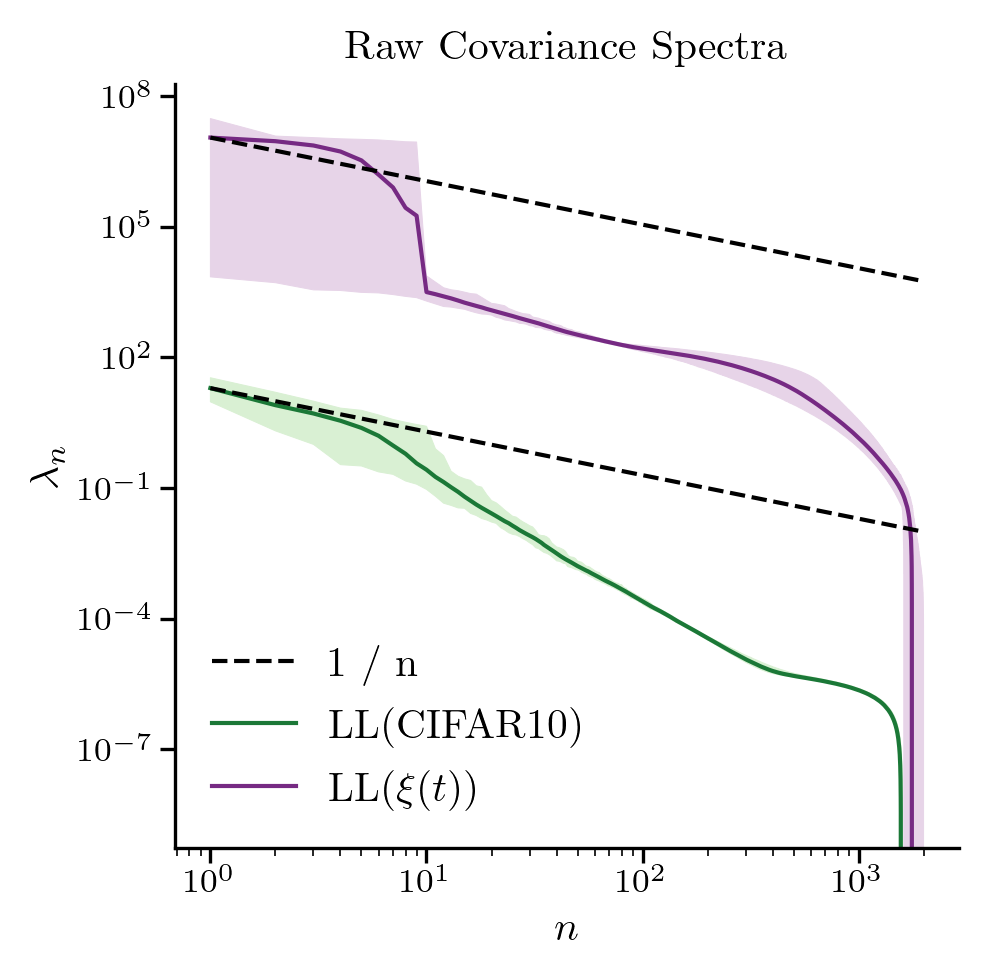

In [190]:
plt.style.use(['seaborn-paper', "./PRLSingleCol.mplstyle"])

fig, ax = plt.subplots()

x = np.arange(1, cifar_spectra_np.shape[1]+1)

# cifar spectra
mean_cifar = np.mean(cifar_spectra_np, axis=0)
min_cifar = np.amin(cifar_spectra_np, axis=0)
max_cifar = np.amax(cifar_spectra_np, axis=0)
std_cifar = np.std(cifar_spectra_np, axis=0)

ax.loglog(x, mean_cifar[0] / x, linestyle='dashed', color='#000000', label=r"1 / n", zorder=3)
ax.loglog(x, mean_cifar, color=c[-1], label=r"LL(CIFAR10)", zorder=2)
ax.fill_between(x, min_cifar, max_cifar, color=c[-3], zorder=0)
#ax.fill_between(np.arange(1, len(mean_cifar)+1), mean_cifar-std_cifar/2, mean_cifar+std_cifar/2, color='#a1d99b', zorder=1)

# gaussian noise spectra
mean_gauss = np.mean(gauss_spectra_np, axis=0)
min_gauss = np.amin(gauss_spectra_np, axis=0)
max_gauss = np.amax(gauss_spectra_np, axis=0)
std_gauss = np.std(gauss_spectra_np, axis=0)

ax.loglog(x, mean_gauss[0] / x, linestyle='dashed', color='#000000', zorder=3)
ax.loglog(x, mean_gauss, color=c[0], label=r"LL($\xi(t)$)", zorder=2)
ax.fill_between(np.arange(1, len(mean_gauss)+1), min_gauss, max_gauss, color=c[2], zorder=0)
#ax.fill_between(np.arange(1, len(mean_gauss)+1), mean_gauss-std_gauss, mean_gauss+std_gauss, color='#bcbddc', zorder=1)

ax.legend()
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\lambda_{n}$")
ax.set_title(r"Raw Covariance Spectra")

fig.savefig("CovarianceSpectraEnsemble.pdf")

### Count Statistic of how many Instances Scale according to Stringer

In [197]:
cifar_scales_stringer_spectra = scales_stringer(cifar_spectra_np)
gauss_scales_stringer_spectra = scales_stringer(gauss_spectra_np)
scales_stringer_spectra = np.logical_and(cifar_scales_stringer_spectra, gauss_scales_stringer_spectra)

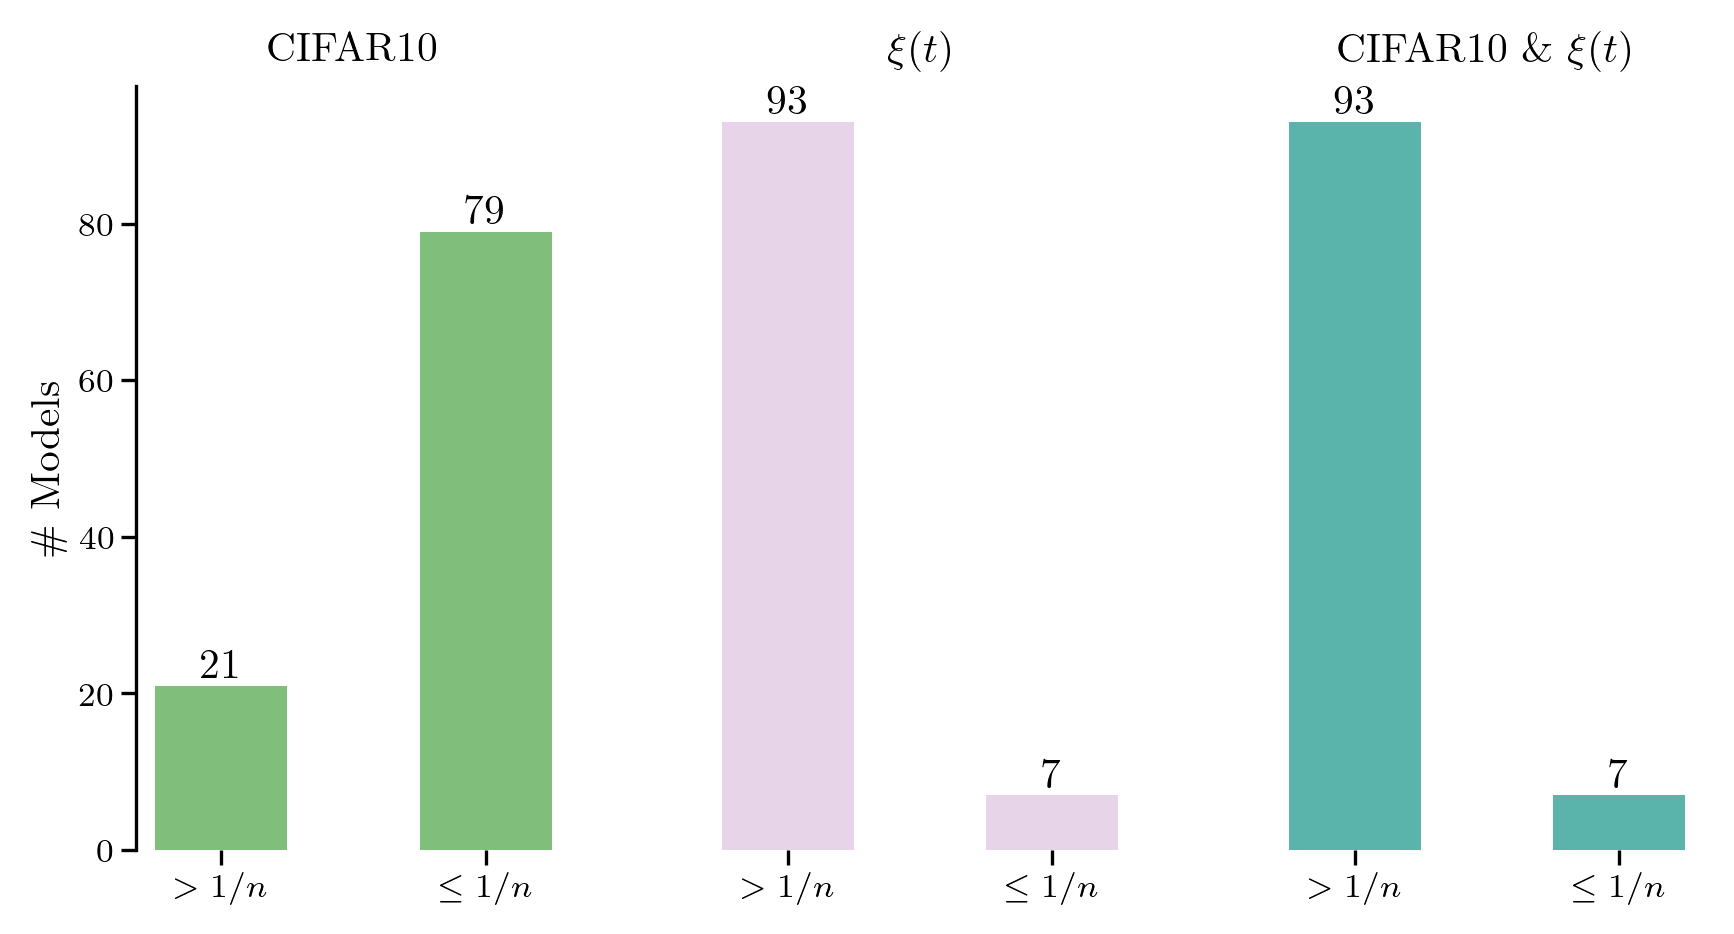

In [208]:
plt.style.use(['seaborn-paper', "./PRLDCol.mplstyle"])
c = colorwheel

fig, axs = plt.subplots(1, 3)

counts, edges, bars = axs[0].hist(cifar_scales_stringer_spectra*1.0, bins=2, rwidth=0.5, color=c[-2])
axs[0].bar_label(bars)
axs[0].spines.bottom.set_visible(False)
axs[0].set_xticks([0.25, 0.75])
axs[0].set_xticklabels([r"$> 1/n$", r"$\leq 1/n$"])
axs[0].set_ylabel(r"\# Models")
axs[0].set_title(r"CIFAR10")

counts, edges, bars = axs[1].hist(gauss_scales_stringer_spectra*1.0, bins=2, rwidth=0.5, color=c[2])
axs[1].bar_label(bars)
axs[1].spines.bottom.set_visible(False)
axs[1].set_xticks([0.25, 0.75])
axs[1].set_xticklabels([r"$> 1/n$", r"$\leq 1/n$"])
axs[1].spines.left.set_visible(False)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_title(r"$\xi(t)$")
#axs[1].set_ylabel(r"\# LL($\xi(t)$)")

counts, edges, bars = axs[2].hist(scales_stringer_spectra*1.0, bins=2, rwidth=0.5, color='#5ab4ac')
axs[2].bar_label(bars)
axs[2].spines.bottom.set_visible(False)
axs[2].set_xticks([0.25, 0.75])
axs[2].set_xticklabels([r"$> 1/n$", r"$\leq 1/n$"])
axs[2].spines.left.set_visible(False)
axs[2].set_yticks([])
axs[2].set_yticklabels([])
axs[2].set_title(r"CIFAR10 \& $\xi(t)$")

# adjust axes
ylim = axs[2].get_ylim()
axs[0].set_ylim(ylim)
axs[1].set_ylim(ylim)
#axs[2].set_ylabel(r"\# LL($\xi(t)$)")

#axs[0].set_title(r"")

fig.savefig("NumberOfModelsThatScaleAccordingToStringer.pdf")

### Selected Covariance Spectra Ensemble

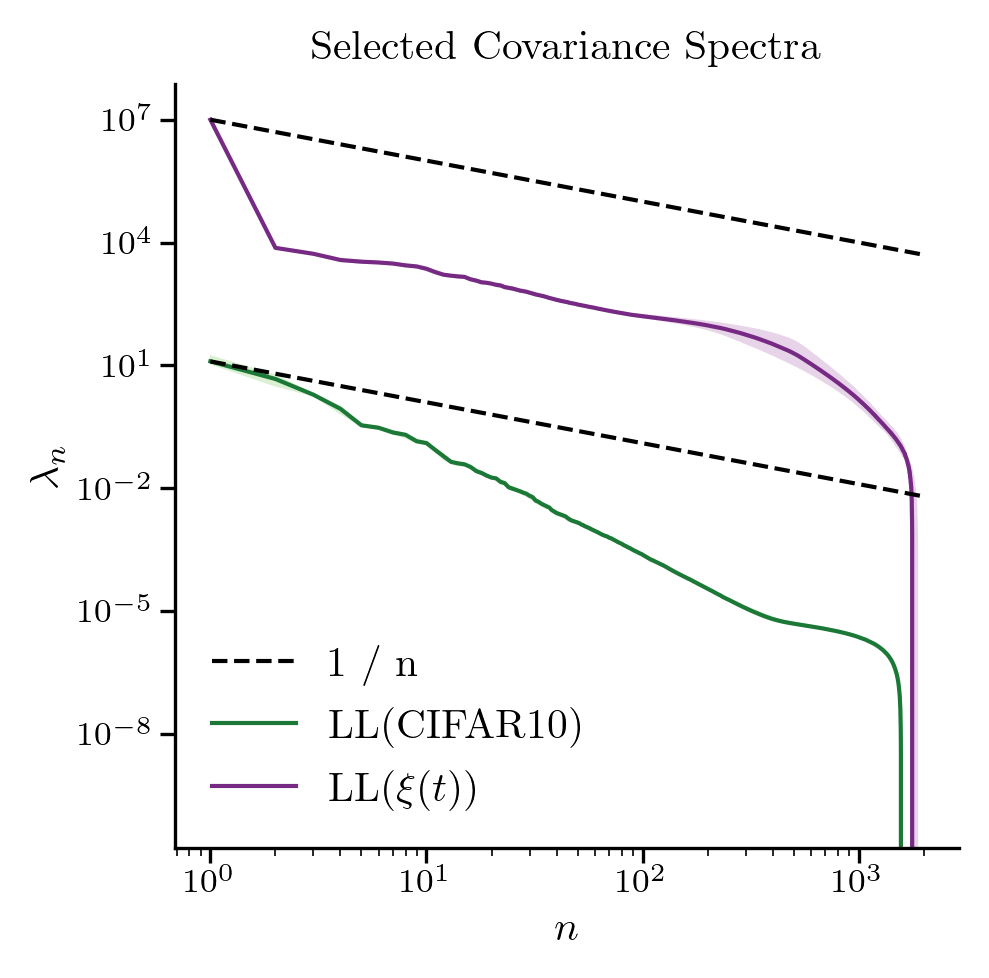

In [207]:
plt.style.use(['seaborn-paper', "./PRLSingleCol.mplstyle"])

fig, ax = plt.subplots()

x = np.arange(1, cifar_spectra_np.shape[1]+1)

# cifar spectra
selected_cifar_spectra_np = cifar_spectra_np[scales_stringer_spectra]
mean_selected_cifar = np.mean(selected_cifar_spectra_np, axis=0)
min_selected_cifar = np.amin(selected_cifar_spectra_np, axis=0)
max_selected_cifar = np.amax(selected_cifar_spectra_np, axis=0)
std_selected_cifar = np.std(selected_cifar_spectra_np, axis=0)

ax.loglog(x, mean_selected_cifar[0] / x, linestyle='dashed', color='#000000', label=r"1 / n", zorder=3)
ax.loglog(x, mean_selected_cifar, color=c[-1], label=r"LL(CIFAR10)", zorder=2)
ax.fill_between(x, min_selected_cifar, max_selected_cifar, color=c[-3], zorder=0)
#ax.fill_between(np.arange(1, len(mean_selected_cifar)+1), mean_selected_cifar-std_selected_cifar/2, mean_selected_cifar+std_selected_cifar/2, color='#a1d99b', zorder=1)

# gaussian noise spectra
selected_gauss_spectra_np = gauss_spectra_np[scales_stringer_spectra]
mean_selected_gauss = np.mean(selected_gauss_spectra_np, axis=0)
min_selected_gauss = np.amin(selected_gauss_spectra_np, axis=0)
max_selected_gauss = np.amax(selected_gauss_spectra_np, axis=0)
std_selected_gauss = np.std(selected_gauss_spectra_np, axis=0)

ax.loglog(x, mean_selected_gauss[0] / x, linestyle='dashed', color='#000000', zorder=3)
ax.loglog(x, mean_selected_gauss, color=c[0], label=r"LL($\xi(t)$)", zorder=2)
ax.fill_between(np.arange(1, len(mean_selected_gauss)+1), min_selected_gauss, max_selected_gauss, color=c[2], zorder=0)
#ax.fill_between(np.arange(1, len(mean_selected_gauss)+1), mean_selected_gauss-std_selected_gauss, mean_selected_gauss+std_selected_gauss, color='#bcbddc', zorder=1)

ax.legend()
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$\lambda_{n}$")
ax.set_title(r"Selected Covariance Spectra")

fig.savefig("SelectedCovarianceSpectraEnsemble.pdf")

# Biological Learning Model

In [1]:
import torch
from torch import nn
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path
from tqdm import tqdm

from context import LocalLearning

from matplotlib import pyplot as plt

train_data = datasets.CIFAR10(
    root = "../data/CIFAR10", train=True, download=True, transform=ToTensor()
)

dataloader_train = DataLoader(
    train_data, batch_size=128, num_workers=4, shuffle=True
)

Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model_path = Path("../data/models/L2UnitCIFAR10_LL/cifar_990.pth")
ll_trained_state = torch.load(model_path)
bio_model = LocalLearning.BioLearningModel(ll_trained_state)
bio_model.to(device)
bio_model.train()

BioLearningModel(
  (local_learning): FKHL3(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (relu_h): ReLU()
  (dense): Linear(in_features=2000, out_features=10, bias=False)
  (relu_f): ReLU()
  (softmax): Softmax(dim=-1)
)

### Visulising parameter distributions pre training

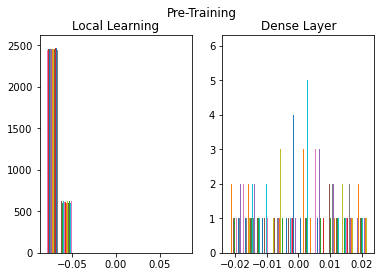

In [5]:
# extract parameters from model
p_iter = bio_model.parameters()
llw = next(p_iter) # locallearning parameters
dw = next(p_iter) # dense weights

# convert to numpy format
llw = llw.detach().cpu().numpy()
dw = dw.detach().cpu().numpy()

# print histograms
fig, axs = plt.subplots(1, 2)
axs[0].hist(llw)
axs[1].hist(dw)
axs[0].set_title("Local Learning")
axs[1].set_title("Dense Layer")
fig.suptitle("Pre-Training")
plt.show()

In [6]:
learning_rate = 1e-4
AdamOpt = Adam(bio_model.parameters(), lr=learning_rate)

In [4]:
def CE_loss(preds: Tensor, labels: Tensor) -> Tensor:
    '''
    Calculates the cross entropy loss between prediction tensor and labels
    Args:
        preds (torch.Tensor):   Model prediction score tensor
                                size = (MB - Minibatch Size, NoC - Number of Classes)
        labels (torch.Tensor):  Dataset labels
                                size = (MB - Minibatch Size)
                                
    Vals:
        CE_loss (torch.Tensor): Mean Cross Entropy loss
                                size = (1,) [scalar]
    '''
    # convert labels into one-hot encoding
    l_oh = F.one_hot(labels, num_classes=preds.size(dim=-1))
    p_label = nn.functional.softmax(l_oh.type(torch.float32), dim=-1)
    # calculate cross entropy along the "distribution"
    p_max = torch.max(preds)
    #shifted_preds = preds - p_max
    shifted_logpreds = torch.log(nn.functional.softmax(preds, dim=-1))
    ce = -torch.sum(p_label*shifted_logpreds, dim=-1)
    # calculate the mean CE
    return torch.mean(ce)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    dev = next(model.parameters()).device
    for batch_no, (features, labels) in enumerate(dataloader):
        # Compute prediction and loss
        preds = model(features.to(dev))
        #labels_one_hot = F.one_hot(labels.to(dev), num_classes=preds.size(dim=-1))
        #loss = torch.pow(preds - labels_one_hot, 6.0).sum()
        loss = loss_fn(preds, labels.to(dev))
        #print(f"CE_loss(Batch {batch_no}) = {loss}")

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
def test(dataloader, model, loss_fn):
    dev = next(model.parameters()).device
    for batch_no, (features, labels) in enumerate(dataloader):
        # Compute prediction and loss
        preds = model(features.to(dev))
        loss = loss_fn(preds, labels.to(dev))

In [5]:
features, labels = next(iter(dataloader_train))
bio_model(features.to(device))

tensor([[  0.0000,   0.0000,   0.0000,  ...,  82.2799,  60.4792,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,  28.5680,  20.9987,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ..., 315.3230, 231.7759,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   5.2925,   3.8902,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,  49.2880,  36.2288,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,  53.8868,  39.6091,   0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [6]:
list(bio_model.parameters())

[Parameter containing:
 tensor([[-0.0737, -0.0736, -0.0732,  ..., -0.0711, -0.0727, -0.0721],
         [-0.0726, -0.0722, -0.0728,  ..., -0.0719, -0.0719, -0.0717],
         [-0.0731, -0.0722, -0.0734,  ..., -0.0722, -0.0735, -0.0732],
         ...,
         [-0.0634, -0.0652, -0.0650,  ..., -0.0646, -0.0636, -0.0633],
         [-0.0646, -0.0658, -0.0651,  ..., -0.0649, -0.0631, -0.0637],
         [-0.0645, -0.0661, -0.0645,  ..., -0.0648, -0.0631, -0.0643]],
        device='cuda:0'),
 Parameter containing:
 tensor([[ 0.0096, -0.0200, -0.0122,  ..., -0.0179, -0.0143, -0.0203],
         [-0.0011,  0.0088, -0.0106,  ...,  0.0131,  0.0083,  0.0162],
         [-0.0055,  0.0151,  0.0175,  ..., -0.0136,  0.0095,  0.0180],
         ...,
         [ 0.0133, -0.0171,  0.0138,  ...,  0.0008, -0.0125, -0.0097],
         [ 0.0107,  0.0136,  0.0151,  ..., -0.0124, -0.0072,  0.0102],
         [ 0.0003,  0.0158,  0.0079,  ..., -0.0122, -0.0018,  0.0037]],
        device='cuda:0', requires_grad=True)]

In [8]:
#ce_loss_fn = CE_loss
ce_loss_fn = nn.CrossEntropyLoss()

In [9]:
noEpochs = 100
with tqdm(range(noEpochs), unit="epoch") as tepoch:
    tepoch.set_description(f"Training epochs")
    for epoch in tepoch:
        train(dataloader_train, bio_model, ce_loss_fn, AdamOpt)

Training epochs: 100%|████████████████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/epoch]


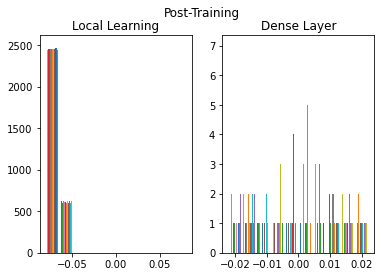

In [11]:
# extract parameters from model
p_iter = bio_model.parameters()
llw = next(p_iter) # locallearning parameters
dw = next(p_iter) # dense weights

# convert to numpy format
llw = llw.detach().cpu().numpy()
dw = dw.detach().cpu().numpy()

# print histograms
fig, axs = plt.subplots(1, 2)
axs[0].hist(llw)
axs[1].hist(dw)
axs[0].set_title("Local Learning")
axs[1].set_title("Dense Layer")
fig.suptitle("Post-Training")
plt.show()

### Encodings of the LocalLearningmodel

# Testing gradient calculation

In [14]:
import torch
from torch import nn
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path
from tqdm import tqdm

from context import LocalLearning

train_data = datasets.CIFAR10(
    root = "../data/CIFAR10", train=True, download=True, transform=ToTensor()
)

dataloader_train = DataLoader(
    train_data, batch_size=128, num_workers=4, shuffle=True
)

Files already downloaded and verified


In [16]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model_path = Path("../data/models/L2UnitCIFAR10_LL/cifar_990.pth")
ll_trained_state = torch.load(model_path)
bio_model = LocalLearning.BioLearningModel(ll_trained_state)
bio_model.to(device)
bio_model.train()

BioLearningModel(
  (local_learning): FKHL3(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (relu_h): ReLU()
  (dense): Linear(in_features=2000, out_features=10, bias=False)
  (relu_f): ReLU()
)

In [17]:
from matplotlib import pyplot as plt

p_iter = bio_model.parameters()
llweights = next(p_iter)
llweights = llweights.detach().cpu().numpy()
dense_weights = next(p_iter)
dense_weights = dense_weights.detach().cpu().numpy()


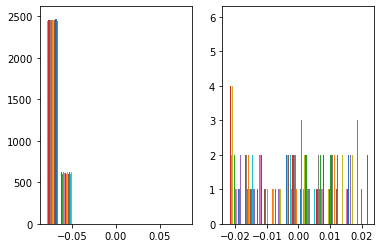

In [19]:
fig, axs = plt.subplots(1, 2)
axs[0].hist(llweights)
axs[1].hist(dense_weights)
plt.show()

In [20]:
ce_loss_fn = nn.CrossEntropyLoss()

In [21]:
features, labels = next(iter(dataloader_train))
p_iter = bio_model.parameters()
dev = next(p_iter).device
pred = bio_model(features.to(dev))
loss = ce_loss_fn(pred, labels.to(dev))
print(f"prediciton_loss = {loss}")

prediciton_loss = 116.77349090576172


In [22]:
loss.backward()

In [26]:
p_iter = bio_model.parameters()
#llweights = next(p_iter)
#llweights_grad = llweights.grad
#llweights = llweights.detach().cpu().numpy()
#llweights_grad = llweights_grad.detach().cpu().numpy()
next(p_iter)
dense_weights = next(p_iter)
dense_weights_grad = dense_weights.grad
dense_weights = dense_weights.detach().cpu().numpy()
dense_weights_grad = dense_weights_grad.detach().cpu().numpy()

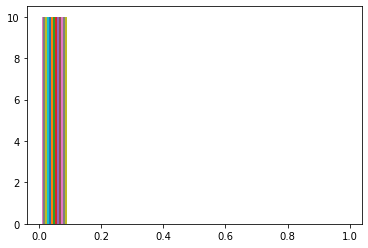

In [31]:
fig, ax = plt.subplots()
ax.hist(dense_weights_grad, bins=10, range=(-0, +1))
plt.show()

In [32]:
dense_weights_grad.sum()

1621.2742

# End-to-end backpropagation model

In [ ]:
import torch
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from pathlib import Path
from tqdm import tqdm

In [ ]:
class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        self.flatten = nn.Flatten()
        self.flatten.requires_grad_(False)
        self.hidden = nn.Linear(32*32*3, 2000, bias=False)
        self.hidden.requires_grad_(False)
        self.relu = nn.ReLU()
        self.dense = nn.Linear(2000, 10, bias=False)
        self.relu_two = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x: Tensor) -> Tensor:
        hidden = self.hidden(self.flatten(x))
        activation = torch.pow(self.relu(hidden), 4.5)
        return self.softmax(self.dense(activation))

classifier = Classifier()
classifier.train()

In [ ]:
train_data = datasets.CIFAR10(
    root = "../data/CIFAR10", train=True, download=True, transform=ToTensor()
)

dataloader_train = DataLoader(
    train_data, batch_size=128, num_workers=4, shuffle=True
)

In [ ]:
list(classifier.parameters())

In [ ]:
import torch.optim 

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

for features, labels in dataloader_train:
    optimizer.zero_grad()
    pred = classifier(features)
    labels_one_hot = torch.zeros(pred.size())
    labels_one_hot.scatter_(-1, labels[..., None], 1.0)
    loss = torch.pow(pred - labels_one_hot, 6.0).sum()
    loss.backward()
    optimizer.step()

In [ ]:
list(classifier.parameters())

# Mikkel's Code

In [20]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from tqdm.notebook import tqdm_notebook as tqdm
from collections import defaultdict
from torchvision import datasets, transforms

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(), # normalize to [0,1]
#     transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)) # standardize data
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [23]:
data_train = datasets.CIFAR10('../data/CIFAR10', train=True, transform=transform)#, download=True)
data_test = datasets.CIFAR10('../data/CIFAR10', train=False, transform=transform)

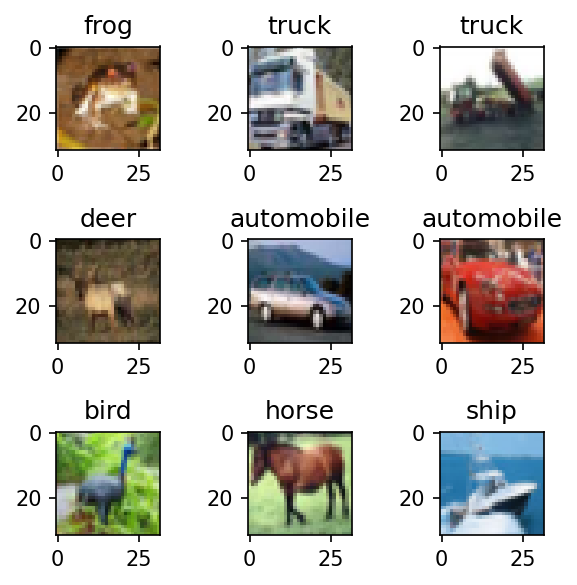

In [27]:
plt.figure(figsize=(4,4), dpi=150)
for i in range(9):  
    plt.subplot(330 + 1 + i)
    img, label = data_train[i]
    plt.imshow(np.fliplr(np.rot90(img.T, -1)))#, cmap=plt.get_cmap('gray'))
    plt.title(data_train.classes[label])
plt.tight_layout()

In [28]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super(Dataset, self).__init__()

        self.x = data.data.astype('float32') / 255.0
        self.y = data.targets
        
    def _get_data(self):
        return self.x

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [29]:
x_train = Dataset(data_train)._get_data()
y_train = torch.Tensor(data_train.targets)
x_test = Dataset(data_train)._get_data()
y_test = torch.Tensor(data_test.targets)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
torch.Size([50000])
(50000, 32, 32, 3)
torch.Size([10000])


In [19]:
def draw_weights(synapses, n_hiddenx, n_hiddeny, n_pixelx=32, n_pixely=32, n_chan=3):
    cnt = 0
    if n_chan:
        shape = (n_pixely, n_pixelx, n_chan)
        HM = np.zeros((n_pixely*n_hiddeny, n_pixelx*n_hiddenx, n_chan))
    else: 
        shape = (n_pixely, n_pixelx)
        HM = np.zeros((n_pixely*n_hiddeny, n_pixelx*n_hiddenx))
    for y in range(n_hiddeny):
        for x in range(n_hiddenx):
            HM[y*n_pixely:(y+1)*n_pixely, x*n_pixelx:(x+1)*n_pixelx] = synapses[cnt].reshape(*shape)
            cnt += 1

    nc = np.max(np.absolute(HM))
    im = plt.imshow(HM, cmap='bwr', vmin=-nc, vmax=nc)
    plt.colorbar(im, ticks=[np.min(HM), 0, np.max(HM)])
    plt.axis('off')

In [34]:
#num_pixel = x_train.shape[1] * x_train.shape[2] * x_train.shape[3] #3072
num_pixel = 32*32*3
num_train = 50000#len(MDdataLoaderTrain)#x_train.shape[0]
#num_test = #x_test.shape[0]
#x_train_flat = x_train.reshape(num_train, num_pixel)
eps0 = 2e-2    # learning rate
Kx = 50
Ky = 50
num_hidden = Kx * Ky    # number of hidden units that are displayed in Ky by Kx array
mu = 0.0
sigma = 1.0
num_epochs = 1000      # number of epochs
num_batch = 1000      # size of the minibatch
prec = 1e-30
delta = 0.4    # Strength of the anti-hebbian learning
p = 2.0        # Lebesgue norm of the weights
k = 2          # ranking parameter, must be integer that is bigger or equal than 2

In [31]:
def synaptic_activation(synapses, inputs):
    return (synapses.sign() * synapses.abs() ** (p - 1)).matmul(inputs)

def learning_activation(indices):
    best_ind, best_k_ind = indices[0], indices[k-1]
    g_i = torch.zeros(num_hidden, num_batch).to(device)
    g_i[best_ind,   torch.arange(num_batch).to(device)] = 1.0
    g_i[best_k_ind, torch.arange(num_batch).to(device)] = -delta
    return g_i


In [46]:
pbar = tqdm(total=num_epochs * num_train // num_batch)

# wrap as Tensor
#x_train_flat = torch.Tensor(x_train_flat).to(device)
flat = torch.nn.Flatten()
synapses = torch.Tensor(num_hidden, num_pixel).normal_(mu, sigma).to(device)

for epoch in range(num_epochs):
    # decay learning rate
    eps = eps0 * (1 - epoch / num_epochs)
    # shuffle data
    #x_train_flat = x_train_flat[torch.randperm(x_train_flat.size(0))]
    
    #for i in range(num_train // num_batch):
    for batch_id, (features, labels) in enumerate(MDdataLoaderTrain):
        
        #inputs = x_train_flat[i * num_batch:(i + 1) * num_batch, :].t()
        inputs = flat(features).T
        
        # I = <W,v> synaptic activation
        tot_input = synaptic_activation(synapses, inputs)
        
        # find indices maximizing the synapse
        _, indices = tot_input.topk(k, dim=0)
        # g(Q) learning activation function
        g_i = learning_activation(indices)
        # Learning algorithm
        xx = (g_i * tot_input).sum(dim=1)
        ds = torch.matmul(g_i, inputs.t()) - xx.unsqueeze(1) * synapses
        
        nc = max(ds.abs().max(), prec)
        
        # the actual update
        synapses += eps * ds / nc 
        ###################
        pbar.update(1)
pbar.close()


  0%|                                                                                       | 0/50000 [01:26<?, ?it/s]


AttributeError: 'Tensor' object has no attribute '__array_interface__'

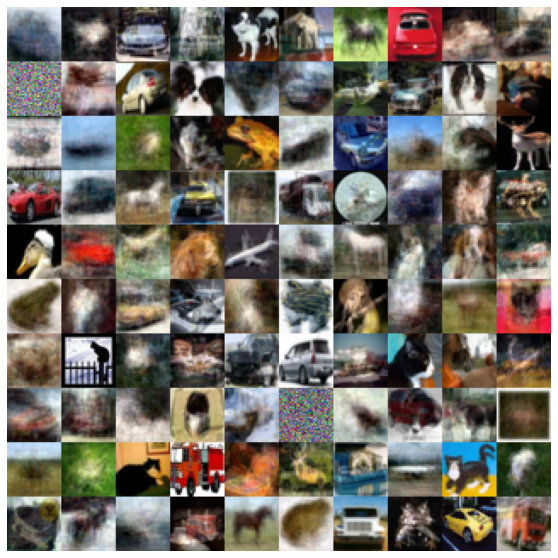

In [36]:
def minmaxnorm(a):
    a_ = a - a.min()
    return a_ / a_.max()


def draw_weights(synapses, n_hiddenx, n_hiddeny, n_pixelx=32, n_pixely=32, n_chan=3):
    cnt = 0
    HM = np.zeros((n_pixely*n_hiddeny, n_pixelx*n_hiddenx, n_chan))
    for y in range(n_hiddeny):
        for x in range(n_hiddenx):
            HM[y*n_pixely:(y+1)*n_pixely, x*n_pixelx:(x+1)*n_pixelx, :] = minmaxnorm(synapses[cnt].reshape(n_pixely, n_pixelx, n_chan))
            cnt += 1

    nc = np.max(np.absolute(HM))
    im = plt.imshow(HM, vmin=-nc, vmax=nc)
    plt.axis('off')
    
fig = plt.figure(figsize = (12.9, 10))
draw_weights(synapses.detach().cpu(), 10, 10)